In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import time

import torchquantum as tq


# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

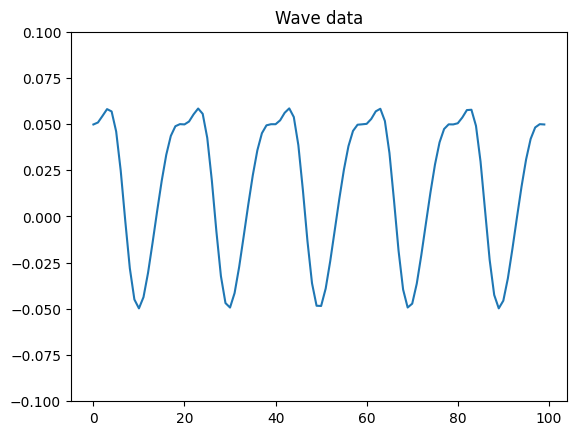

In [2]:
# Generate sine and cosine waves
def generate_sine_cosine_data(seq_length, num_samples):
    x = np.linspace(0, 10 * np.pi, seq_length)
    sine_wave = (0.64*np.sin(x)**2 + np.cos(x) + 0.3*np.sin(x)**3) * np.exp(-3)

    data = np.vstack([sine_wave]).T
    data = np.tile(data, (num_samples, 1))  # Repeat the pattern
    return data

SEQ_LENGTH = 100  # Length of each sequence
NUM_SAMPLES = 1000  # Number of sequences

data = generate_sine_cosine_data(SEQ_LENGTH, NUM_SAMPLES)
plt.plot(data[:SEQ_LENGTH])
plt.ylim(-0.1, 0.1)
plt.title("Wave data")
plt.show()

# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(data)

In [3]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, index):
        x = self.data[index:index + self.seq_length]
        y = self.data[index + 1:index + self.seq_length + 1]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

dataset = TimeSeriesDataset(data_normalized, SEQ_LENGTH)
train_loader = DataLoader(dataset, batch_size=256, shuffle=True)

In [4]:


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate, output_dim):
        super(LSTMModel, self).__init__()
        # Assuming input_shape is a tuple: (timesteps, features)
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, output_dim)  

    def forward(self, x):
        # Apply the first LSTM
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        # Apply the second LSTM
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        # Flatten the output for the Dense layer
        x = self.fc(x)
        return x

# Define model parameters
INPUT_DIM = data.shape[1]  # Number of features
HIDDEN_DIM = 50
DROPOUT_RATE = 0.2
OUTPUT_DIM = data.shape[1]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LSTMModel(INPUT_DIM, HIDDEN_DIM, DROPOUT_RATE, OUTPUT_DIM).to(device)

In [5]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [6]:

# Training loop
NUM_EPOCHS = 1
model.train()
loss_list = [] 
for epoch in range(NUM_EPOCHS):
    for i, (inputs, targets) in enumerate(train_loader):
        since_batch = time.time()
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss_list.append(loss.item()) #loss.cpu().detach().numpy())
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}, batch time: {time.time() - since_batch:.2f}")

    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {loss.item():.4f}')

Epoch [1/1], Step [1/391], Loss: 0.5682, batch time: 0.12
Epoch [1/1], Step [101/391], Loss: 0.0400, batch time: 0.00
Epoch [1/1], Step [201/391], Loss: 0.0252, batch time: 0.00
Epoch [1/1], Step [301/391], Loss: 0.0189, batch time: 0.00
Epoch [1/1], Loss: 0.0159


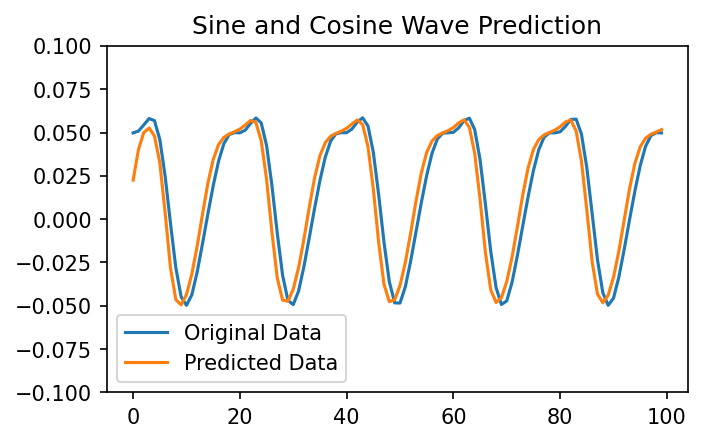

In [8]:
# Switch model to evaluation mode
model.eval()

# Generate predictions for the last sequence
with torch.no_grad():
    test_inputs = torch.tensor(data_normalized[-SEQ_LENGTH:], dtype=torch.float32).unsqueeze(0).to(device)
    predictions = model(test_inputs).cpu().numpy().squeeze()

# Inverse transform predictions
predictions_rescaled = scaler.inverse_transform(predictions.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(5, 3), dpi = 150)
plt.plot(data[-SEQ_LENGTH:], label='Original Data')
plt.plot(predictions_rescaled, label='Predicted Data')
plt.ylim(-0.1, 0.1)
plt.legend()
plt.title("Sine and Cosine Wave Prediction")
plt.show()

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('GPU ==' ,torch.cuda.is_available())
numpy_weights = {}
nw_list = [] 
nw_list_normal = []
name_list = [] 
for name, param in model.state_dict().items():
    name_list.append(name)
    print(name)
    numpy_weights[name] = param.cpu().numpy()
for i in numpy_weights:
    nw_list.append(list(numpy_weights[i].flatten()))
for i in nw_list:
    for j in i:
        nw_list_normal.append(j)
print("# of NN parameters: ", len(nw_list_normal))
n_qubits = int(np.ceil(np.log2(len(nw_list_normal))))
print("Required qubit number: ", n_qubits)

n_qubit = n_qubits

GPU == True
lstm1.weight_ih_l0
lstm1.weight_hh_l0
lstm1.bias_ih_l0
lstm1.bias_hh_l0
lstm2.weight_ih_l0
lstm2.weight_hh_l0
lstm2.bias_ih_l0
lstm2.bias_hh_l0
fc.weight
fc.bias
# of NN parameters:  31051
Required qubit number:  15


In [10]:
def probs_to_weights(probs_, scaling_coefficient):

    new_state_dict = {}
    data_iterator = probs_.view(-1)

    for index, (name, param) in enumerate(model.state_dict().items()):
        
        shape = param.shape
        num_elements = param.numel()
        chunk = data_iterator[:num_elements].reshape(shape)
        ## Flood project special ##

        new_state_dict[name] = scaling_coefficient[0][index]*chunk
        ############################
        data_iterator = data_iterator[num_elements:]
        
    return new_state_dict

def generate_qubit_states_torch(n_qubit):
    # Create a tensor of shape (2**n_qubit, n_qubit) with all possible combinations of 0 and 1
    all_states = torch.cartesian_prod(*[torch.tensor([-1, 1]) for _ in range(n_qubit)])
    return all_states

In [11]:
class QuantumTrain(nn.Module):
    class QLayer(nn.Module):
        def __init__(self, n_blocks):
            super().__init__()
            self.n_wires = int(np.ceil(np.log2(len(nw_list_normal)))),
            self.n_wires = self.n_wires[0]
            self.n_blocks = n_blocks
            # self.scaling_QT = scaling_QT
            self.ry_layers = tq.QuantumModuleList()
            self.cnot_layers = tq.QuantumModuleList()
            # self.measure = tq.MeasureAll(tq.PauliZ)
            for _ in range(self.n_blocks):
                self.ry_layers.append(
                    tq.Op1QAllLayer(
                        op=tq.RY,
                        n_wires=self.n_wires,
                        has_params=True,
                        trainable=True,
                    )
                )
                self.cnot_layers.append(
                    tq.Op2QAllLayer(
                        op=tq.CNOT,
                        n_wires=self.n_wires,
                        has_params=False,
                        trainable=False,
                        circular=True,
                    )
                )
                
        def forward(self):
            qdev = tq.QuantumDevice(
                n_wires=self.n_wires, bsz=1, device=next(self.parameters()).device
            )

            
            for k in range(self.n_blocks):
                self.ry_layers[k](qdev)
                self.cnot_layers[k](qdev)
                
            state_mag = qdev.get_states_1d().abs()[0] 
            state_mag = state_mag[:len(nw_list_normal)]
            x = torch.abs(state_mag) ** 2
            # x = torch.log(x)
            x = x.reshape(len(nw_list_normal),1)

            x.to(device)
            return x
        
        
    class MappingModel(nn.Module):
        def __init__(self, input_size, hidden_sizes, output_size):
            super().__init__()
            # Initialize layers: an input layer, multiple hidden layers, and an output layer
            self.input_layer = nn.Linear(input_size, hidden_sizes[0])
            self.hidden_layers = nn.ModuleList([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]) for i in range(len(hidden_sizes)-1)])
            self.output_layer = nn.Linear(hidden_sizes[-1], output_size)
            
        def forward(self, X):
            # Ensure the input tensor is the same type as the weights
            X = X.type_as(self.input_layer.weight)
            X = self.input_layer(X)
            for hidden in self.hidden_layers:
                X = hidden(X)
            output = self.output_layer(X)
            return output
        
    
    class ScalingModel_QT(nn.Module):
        def __init__(self, output_size):
            super().__init__()
            # Initialize a parameter that will be learned to represent the constant output
            initial_values = [0.1, 0.8, 0.3]
            # self.output = nn.Parameter(torch.randn(output_size))
            self.output = nn.Parameter(torch.tensor(initial_values))
            
        def forward(self, X):
            # Return the learned output parameter regardless of the input
            return self.output.expand(X.size(0), -1)
            


    class ScalingModel(nn.Module):
        def __init__(self, output_size):
            super().__init__()
            # Initialize a parameter that will be learned to represent the constant output
            initial_values = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 26, 37]
            # self.output = nn.Parameter(torch.randn(output_size))
            self.output = nn.Parameter(torch.tensor(initial_values))

        def forward(self, X):
            # Return the learned output parameter regardless of the input
            return self.output.expand(X.size(0), -1)


    def __init__(self):
        """
        Definition of the *dressed* layout.
        """
        super().__init__()
        self.MappingNetwork = self.MappingModel(n_qubit+1, [32, 64, 64, 64, 32], 1).to(device)  
        
        # self.MappingNetwork = self.ConvMappingModel()
        # output_size = 10
        # # hidden_sizes = [20, 30, 20]  # Example hidden layer sizes
        # # model = ScalingModel(output_size, hidden_sizes)
        
        self.QuantumNN = self.QLayer(q_depth).to(device)   #arch={"n_blocks": q_depth})
        self.ScalingNetwork = self.ScalingModel(output_size=10).to(device)
        self.ScalingQTNetwork = self.ScalingModel_QT(output_size=3).to(device)
        # self.scaling_coeff_QT = self.ScalingQTNetwork(torch.tensor([0.1]))[0]
        

    def forward(self, x):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """
        device = x.device
        # rand_input_data = torch.randn(1)  # Even though the input size is arbitrary, it doesn't affect the output of scaling model
        # self.QuantumNN = self.QLayer(q_depth, self.scaling_coeff_QT).to(device)   #arch={"n_blocks": q_depth})

        self.scaling_coeff = self.ScalingNetwork(torch.tensor([0.1]))
        self.scaling_coeff_QT = self.ScalingQTNetwork(torch.tensor([0.1]))[0]

        probs_ = self.QuantumNN()
        
        easy_scale_coeff = 2**(n_qubit-1)
        gamma = self.scaling_coeff_QT[0] #0.1
        beta  = self.scaling_coeff_QT[1] #0.8
        alpha = self.scaling_coeff_QT[2] #0.3
        
        probs_ = (beta*torch.tanh(gamma*easy_scale_coeff*probs_))**(alpha) 
        probs_ = probs_ - torch.mean(probs_)
        probs_ = probs_[:len(nw_list_normal)]

        
        # Generate qubit states using PyTorch
        qubit_states_torch = generate_qubit_states_torch(n_qubit)[:len(nw_list_normal)]
        qubit_states_torch = qubit_states_torch.to(device)

        # Combine qubit states with probability values using PyTorch
        combined_data_torch = torch.cat((qubit_states_torch, probs_), dim=1)
        combined_data_torch = combined_data_torch.reshape(len(nw_list_normal), 1, n_qubit+1)
        
        prob_val_post_processed = self.MappingNetwork(combined_data_torch)
        prob_val_post_processed = prob_val_post_processed - prob_val_post_processed.mean()
        
        
        # construct the state_dict from above calculation results 
        state_dict = probs_to_weights(prob_val_post_processed, self.scaling_coeff)
        # np.save('qt_weight_6_3.npy', state_dict) 

        ######## 
            
        dtype = torch.float32  # Ensure all tensors are of this type
        
        # LSTM layer 1 parameters
        lstm1_weight_ih = state_dict['lstm1.weight_ih_l0'].to(device).type(dtype)
        lstm1_weight_hh = state_dict['lstm1.weight_hh_l0'].to(device).type(dtype)
        lstm1_bias_ih = state_dict['lstm1.bias_ih_l0'].to(device).type(dtype)
        lstm1_bias_hh = state_dict['lstm1.bias_hh_l0'].to(device).type(dtype)

        # LSTM layer 2 parameters
        lstm2_weight_ih = state_dict['lstm2.weight_ih_l0'].to(device).type(dtype)
        lstm2_weight_hh = state_dict['lstm2.weight_hh_l0'].to(device).type(dtype)
        lstm2_bias_ih = state_dict['lstm2.bias_ih_l0'].to(device).type(dtype)
        lstm2_bias_hh = state_dict['lstm2.bias_hh_l0'].to(device).type(dtype)

        # Fully connected layer parameters
        fc_weight = state_dict['fc.weight'].to(device).type(dtype)
        fc_bias = state_dict['fc.bias'].to(device).type(dtype)
        
        # Model reconstruction
        h0 = torch.zeros(1, x.size(0), 50).to(device).type(dtype)
        c0 = torch.zeros(1, x.size(0), 50).to(device).type(dtype)
        lstm_layer_1 = nn.LSTM(input_size=1, hidden_size=50, batch_first=True)
        lstm_layer_1.to(device)
        
        getattr(lstm_layer_1, 'weight_ih_l0').data.copy_(lstm1_weight_ih)
        getattr(lstm_layer_1, 'weight_hh_l0').data.copy_(lstm1_weight_hh)
        getattr(lstm_layer_1, 'bias_ih_l0').data.copy_(lstm1_bias_ih)
        getattr(lstm_layer_1, 'bias_hh_l0').data.copy_(lstm1_bias_hh)


        lstm_layer_2 = nn.LSTM(input_size=50, hidden_size=50, batch_first=True)
        lstm_layer_2.to(device)
        
        getattr(lstm_layer_2, 'weight_ih_l0').data.copy_(lstm2_weight_ih)
        getattr(lstm_layer_2, 'weight_hh_l0').data.copy_(lstm2_weight_hh)
        getattr(lstm_layer_2, 'bias_ih_l0').data.copy_(lstm2_bias_ih)
        getattr(lstm_layer_2, 'bias_hh_l0').data.copy_(lstm2_bias_hh)

        x, (hn, cn) = lstm_layer_1(x, (h0, c0))
        # x = F.dropout(x, 0.2, training=model.training)
        x, _ = lstm_layer_2(x, (hn, cn))
        # x = F.dropout(x, 0.2, training=model.training)
        x = F.linear(x, fc_weight, fc_bias)
        
        return x

In [12]:
q_depth  = 15
model_qt = QuantumTrain().to(device)


In [13]:
model_qt_n_para = sum(p.numel() for p in model_qt.parameters() if p.requires_grad)
print(f"Number of training parameters in the QT-LSTM: {model_qt_n_para}")

Number of training parameters in the QT-LSTM: 13327


In [14]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_qt.parameters(), lr=1e-4, eps = 1e-3)

# Training loop
NUM_EPOCHS = 3
model_qt.train()
loss_list = [] 
loss_best =1e6

for epoch in range(NUM_EPOCHS):
    for i, (inputs, targets) in enumerate(train_loader):
        since_batch = time.time()
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model_qt(inputs)
        loss = criterion(outputs, targets)
        loss_list.append(loss.item()) #loss.cpu().detach().numpy())
        if loss.item() < loss_best:
            torch.save(model_qt, 'model_/tq_model_loss_bsf')
            loss_best = loss.item()
            # print(f"loss_best = {loss_best}")

        loss.backward()
        optimizer.step()
        if i % 100 == 0 :
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}, batch time: {time.time() - since_batch:.2f}")

print(f"loss_best = {loss_best}")
    # print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {loss.item():.4f}')

Epoch [1/3], Step [1/391], Loss: 0.7688, batch time: 0.25
Epoch [1/3], Step [101/391], Loss: 0.3091, batch time: 0.10
Epoch [1/3], Step [201/391], Loss: 0.0878, batch time: 0.10
Epoch [1/3], Step [301/391], Loss: 0.1460, batch time: 0.10
Epoch [2/3], Step [1/391], Loss: 0.1020, batch time: 0.10
Epoch [2/3], Step [101/391], Loss: 0.0543, batch time: 0.12
Epoch [2/3], Step [201/391], Loss: 0.0459, batch time: 0.17
Epoch [2/3], Step [301/391], Loss: 0.0144, batch time: 0.11
Epoch [3/3], Step [1/391], Loss: 0.0147, batch time: 0.10
Epoch [3/3], Step [101/391], Loss: 0.0157, batch time: 0.10
Epoch [3/3], Step [201/391], Loss: 0.0164, batch time: 0.13
Epoch [3/3], Step [301/391], Loss: 0.0181, batch time: 0.10
loss_best = 0.013709977269172668


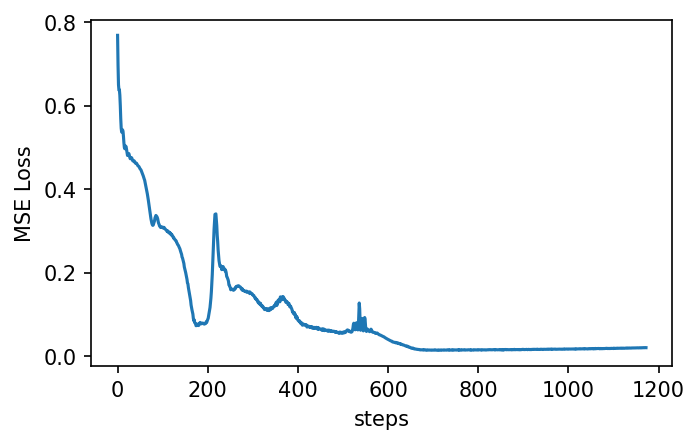

In [20]:
# Plot the results
plt.figure(figsize=(5, 3), dpi = 150)
plt.plot(loss_list)
plt.xlabel("steps")
plt.ylabel("MSE Loss")
plt.show()

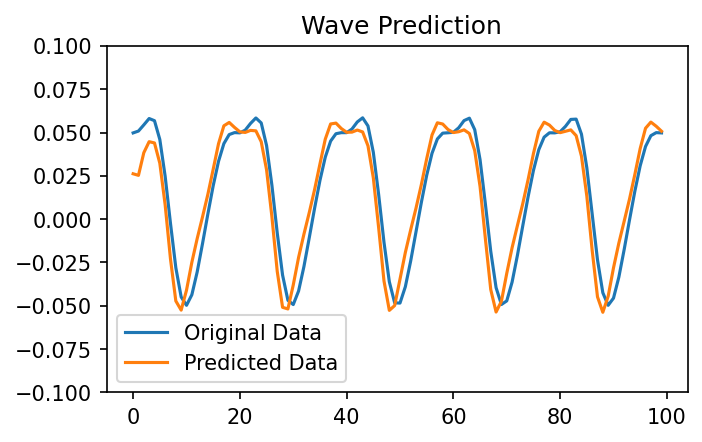

In [17]:
model_qt = torch.load('model_/tq_model_loss_bsf')
# Switch model to evaluation mode
model_qt.eval()

# Generate predictions for the last sequence
with torch.no_grad():
    test_inputs = torch.tensor(data_normalized[-SEQ_LENGTH:], dtype=torch.float32).unsqueeze(0).to(device)
    predictions = model_qt(test_inputs).cpu().numpy().squeeze()

# Inverse transform predictions
predictions_rescaled = scaler.inverse_transform(predictions.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(5, 3), dpi = 150)
plt.plot(data[-SEQ_LENGTH:], label='Original Data')
plt.plot(predictions_rescaled, label='Predicted Data')
plt.ylim(-0.1, 0.1)
plt.legend()
plt.title(" Wave Prediction")
plt.show()